# Term Frequencies partitioned by gender

In previous notebooks, we have used speakers' genders to apply a gender label to each talk. The gender labels used are: male, female, and not one gender. We note that the list of speakers in the corpus of TED talks identify on the gender binary, at least in the public facing documents about them (which include their TED talk bios and third party websites and publicity). 




## Summary

This is the second attempt to look a freqencies by gender. In the first attempt in `03-Terms-by-gender`, we applied the method from `01-Terms.ipynb` on just the talks gendered as "female." This approach has some limits, chiefly that if we also do the same to "male" talks, we have no clear method for comparing how different words appear in talks by either binary gender. 

In this second attempt, we will instead load the talks such that the male talks are all together, followed by the female talks, and finally followed by those talks that are neither binary gender. 

With the data loaded in this partitioned manner, we will then count the words in each of the texts and like with the previous attempt, addres the matter of parentheticals head on. Much of this work occurs in a separate notebook, and the explanations of how that work relates to this process is detailed in `01-Terms.ipynb`.

In this notebook, we will **not** take each subset individually but rather as one partitioned set (first talks labeled male, female, and not one gender) and complete the following procedure: 
* Remove the parentheticals
* Create term matrix from the resulting vocabulary
* Adjust the threshold for a word to be included in the term-matrix
* Export the resulting as a CSV


## Load Imports and Data

In [1]:
# IMPORTS

import numpy as np
import pandas as pd, re, csv, nltk
from sklearn.feature_extraction.text import CountVectorizer

import matplotlib.pyplot as plt

In [2]:
# LOCAL FUNCTION --> Explained in 01-Terms.ipynb

parentheticals = [ "\(laughter\)", "\(applause\)", "\(music\)", "\(video\)", 
                  "\(laughs\)", "\(applause ends\)", "\(audio\)", "\(singing\)", 
                  "\(music ends\)", "\(cheers\)", "\(cheering\)", "\(recording\)", 
                  "\(beatboxing\)", "\(audience\)", "\(guitar strum\)", 
                  "\(clicks metronome\)", "\(sighs\)", "\(guitar\)", "\(marimba sounds\)", 
                  "\(drum sounds\)" ]

def remove_parentheticals(text):
    global parentheticals
    new_text = text
    for rgx_match in parentheticals:
        new_text = re.sub(rgx_match, ' ', new_text.lower(), flags=re.IGNORECASE)
    return new_text

In [3]:
# Load data

# Load binary gendered talks 
talks_male = pd.read_csv('talks_male.csv', index_col='Talk_ID')
talks_female = pd.read_csv('talks_female.csv', index_col='Talk_ID')

# No one gender ==> NOG
talks_nog = pd.read_csv('talks_nog.csv', index_col='Talk_ID')

In [4]:
print(talks_male.shape[0],talks_female.shape[0],talks_nog.shape[0])

714 260 8


In [5]:
# Concatenate the data

all_talks = pd.concat([talks_male,talks_female,talks_nog])
all_talks.shape

(982, 14)

In [6]:
# check that the shape is what we expect

print(all_talks.shape[0] == (talks_male.shape[0]+talks_female.shape[0]+talks_nog.shape[0]))
print(all_talks.shape[1] == talks_nog.shape[1])

True
True


## Raw Frequencies

The goal of this notebook is to establish how we are going to elicit our features, our words, from the collection of talks. Thus, the only column we are interested in is the one with the texts of the talks. While we recognize the utility of having the data in one file, we are looking to minimize individual file sizes, and also make it possible only to load the data we need for any particular task. For that reason, we have chosen to create a number of CSV files, using the ID number that TED assigns each talk as it publishes them to its website.

For this first experiment, we keep it simple by creating two lists, one of the talk IDs and one of the texts themselves: we will only be using the IDs later when we write the DTM to a CSV. This ID will allow us later to correlate the DTM with metadata associated with each talk: the speaker, her biography, the talk's popularity, etc. 

In [7]:
partitioned_texts = all_talks.text.tolist()

**Nota bene**: If you are using this notebook to re-create the basic TF matrix you can stop here and jump to the end of this notebook.

There are a number of ways to get term frequencies, but **SciKit-Learn**'s `CountVectorizer` offers a one-stop shop for generating a DTM from which we can examine words as well as generate BoW-products like topic models. This is made possible by the interoperability between `CountVectorizer` and the other vectorizers and models available in `sklearn`.



In our first experiment, we run `CountVectorizer` unadorned. The default options are: lowercase everything, get rid of all punctuation, make a word out of anything more than two characters long. The only thing that might not be welcome is the splitting of contractions. For now, we will leave things as they are. (Also, please note, no stopwords were used, so we have an unfiltered word list and no pre-processing of the texts is done.)

CHECK THIS ASSERTION: Since `CountVectorizer` only counts when *fitting* and does not engage in any kind of normalization or centering, *transforming*, there is no need to break the two functionalities out in the code that follows.

In [8]:
# If you want to pass options, pass them here:
vectorizer = CountVectorizer( lowercase = True )

# fit the model to the data 
# vecs = vectorizer.fit(partitioned_texts)
X = vectorizer.fit_transform(partitioned_texts)

# see how many features we have
X.shape

(982, 39418)

39418 tokens is our raw, unfiltered, no pre-processing baseline. It includes, as we will see, a number of artifacts of the TED transcription process, including a variety of ways to spell out *ah*, the use of numerals for a host of things -- from dates to counts and everything in between, and some things which actually take places outside the talk itself, like audience laughter, which we here term *parentheticals*. (Accounting for all these artifacts requires a number of closer inspections, which take place in a separate notebook: [Term Artifacts](Terms-02).)

In [9]:
raw_df = pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names())
raw_df.shape

(982, 39418)

In [10]:
col_list = list(raw_df.columns)

len(col_list)

39418

In [37]:
col_list.index("aa")

782

In [12]:
col_list[782:792]

['aa',
 'aaa',
 'aaaa',
 'aaaaa',
 'aaaah',
 'aag',
 'aah',
 'aakash',
 'aargh',
 'aaron']

In [13]:
col_list.index("aakash")

789

As with the full corpus (`01-Terms.ipynb`), a hand inspection of the output above turned up a couple of interesting issues. For more details on the full corpus see `01-Terms-02-Parentheticals` for parentheticals mixed in with the text of the talks and `01-Terms-03-Numbers` for numbers feature in the talks regularly. 

There are also some interesting tokenization dimensions to a crowd-sourced transcription technology for the female talks:

| Term    | Freq |
|:---------|---:|
|aa       |4 |
|aaaaa    |1  |
|aah      |3 |

Though similar can be said for the male talks: 


In [38]:
# Crowd noises are at 782 through 788

male_crowd = raw_df.iloc[:714,782:789].sum()
print(male_crowd)

female_crowd = raw_df.iloc[714:(714+260),782:789].sum()
print(female_crowd)

nog_crowd = raw_df.iloc[-8:,782:789].sum()
print(nog_crowd)

aa       7
aaa      6
aaaa     2
aaaaa    0
aaaah    2
aag      1
aah      7
dtype: int64
aa       4
aaa      0
aaaa     0
aaaaa    1
aaaah    0
aag      0
aah      3
dtype: int64
aa       0
aaa      0
aaaa     0
aaaaa    0
aaaah    0
aag      0
aah      0
dtype: int64


In [15]:
# print(raw_df.iloc[-8:])

In [17]:
# First words start at index 789

789/39418

## About 2% of the way into the word list

0.020016236237252016

In [44]:
# See how many of the non-words each talk has (regardless of how many times each non-word appears.)
m_test = (raw_df.iloc[:714,:789]>0).sum(axis = 1)
f_test = (raw_df.iloc[714:(714+260),:789]>0).sum(axis = 1)

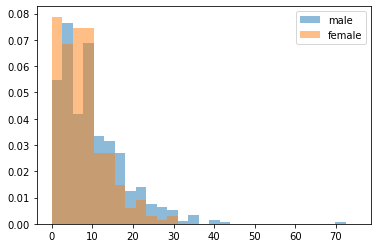

In [45]:
# https://stackoverflow.com/questions/6871201/plot-two-histograms-on-single-chart-with-matplotlib
bins = np.linspace(0,75,30)
plt.hist(m_test, bins, density=True,  alpha=0.5, label = "male")
plt.hist(f_test, bins, density=True, alpha=0.5, label = "female")
plt.legend(loc='upper right')
plt.show()

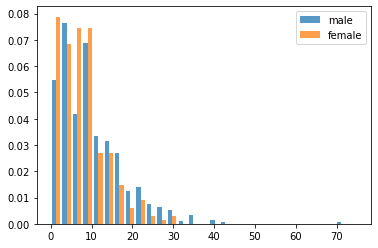

In [46]:
plt.hist([m_test,f_test], bins, density=True, alpha=0.75, label=['male','female'])
plt.legend(loc='upper right')
plt.show()

In [34]:
raw_series = raw_df.sum()

In [35]:
raw_series.head()

00              4
000          1187
000000004       1
000042          1
0001            1
dtype: int64

Another caveat from the `01-Terms.ipynb` notebook: 
> The rest of the hand-examination turns up no other issues, so the basic vectorization built into `sklearn` appears to be satisfactory, with the only exception being its breaking of contractions at the apostrophe: e.g., *isn't* becomes *isn* and *'t*, with the latter being thrown away as too small -- which means that the indefinite article *a(n)* is also not present in the frequencies, but the definite article *the* remains. 

## Remove the non-words:

In [47]:
trunc_df = raw_df.iloc[:,789:]
trunc_df.shape


(982, 38629)

In [48]:
raw_df.shape[1] - trunc_df.shape[1]

789

In [55]:
male_tdf = trunc_df.iloc[:714,:]
male_tdf.shape

(714, 38629)

In [56]:
female_tdf = trunc_df.iloc[714:(714+260),:]
female_tdf.shape

(260, 38629)

In [57]:
nog_tdf = trunc_df.iloc[-8:,:]
nog_tdf.shape

(8, 38629)

In [62]:
# How many times does each word appear across the whole corpus of male talks? 
count_per_word_m = male_tdf.sum(axis = 0)

# How many talks does each word appear in?
talks_per_word_m = (male_tdf > 0).sum(axis = 0)

# How many words are in each talk? 
words_in_talk_m = male_tdf.sum(axis = 1)

# How many unique words per talk? 
unique_words_talk_m = (male_tdf > 0).sum(axis = 1)

In [63]:
print('Smallest number of times a word is used is',count_per_word_m.min() ,
      'while the largest number of times is',count_per_word_m.max())
print('The average number of times a word is used is',round(count_per_word_m.mean(),2) ,
      'with a standard deviation of',round(count_per_word_m.std(),2),
      '\n The median is', count_per_word_m.median() )

Smallest number of times a word is used is 0 while the largest number of times is 71190
The average number of times a word is used is 36.78 with a standard deviation of 679.59 
 The median is 2.0


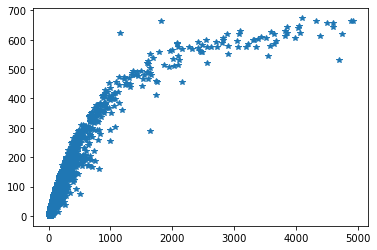

In [64]:
inds = count_per_word_m < 5000

plt.plot(count_per_word_m[inds],talks_per_word_m[inds],"*")

In [65]:
# How many times does each word appear across the whole corpus of female talks? 
count_per_word_f = female_tdf.sum(axis = 0)

# How many talks does each word appear in?
talks_per_word_f = (female_tdf > 0).sum(axis = 0)

# How many words are in each talk? 
words_in_talk_f = female_tdf.sum(axis = 1)

# How many unique words per talk? 
unique_words_talk_f = (female_tdf > 0).sum(axis = 1)

In [66]:
print('Smallest number of times a word is used is',count_per_word_f.min() ,
      'while the largest number of times is',count_per_word_f.max())
print('The average number of times a word is used is',round(count_per_word_f.mean(),2) ,
      'with a standard deviation of',round(count_per_word_f.std(),2),
      '\n The median is', count_per_word_f.median() )

Smallest number of times a word is used is 0 while the largest number of times is 21585
The average number of times a word is used is 12.18 with a standard deviation of 218.3 
 The median is 1.0


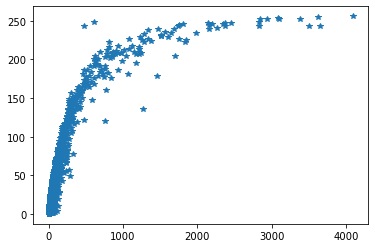

In [67]:
inds = count_per_word_f < 5000

plt.plot(count_per_word_f[inds],talks_per_word_f[inds],"*")

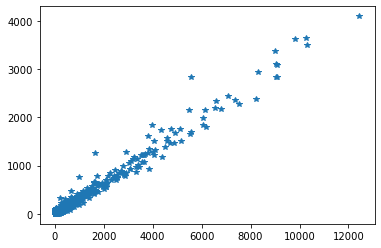

In [69]:
plt.plot(count_per_word_m[inds],count_per_word_f[inds],"*")

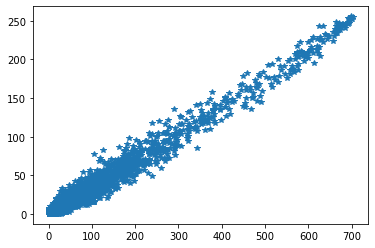

In [70]:
plt.plot(talks_per_word_m[inds],talks_per_word_f[inds],"*")

In [71]:
# How many times does each word appear across the whole corpus of female talks? 
count_per_word_n = nog_tdf.sum(axis = 0)

# How many talks does each word appear in?
talks_per_word_n = (nog_tdf > 0).sum(axis = 0)

# How many words are in each talk? 
words_in_talk_n = nog_tdf.sum(axis = 1)

# How many unique words per talk? 
unique_words_talk_n = (nog_tdf > 0).sum(axis = 1)

In [72]:
print('Smallest number of times a word is used is',count_per_word_n.min() ,
      'while the largest number of times is',count_per_word_n.max())
print('The average number of times a word is used is',round(count_per_word_n.mean(),2) ,
      'with a standard deviation of',round(count_per_word_n.std(),2),
      '\n The median is', count_per_word_n.median() )

Smallest number of times a word is used is 0 while the largest number of times is 661
The average number of times a word is used is 0.4 with a standard deviation of 6.95 
 The median is 0.0


## Revised Frequencies without Parentheticals

For more on the work leading up to this regex, see the `01-Terms-02-Parentheticals` notebook: it contains a number of experiments, which were vexed by sklearn's vectorizer only accepting strings as inputs. (While gensim appears to accept texts as lists of words, we are hoping, I think, to keep our code base as simple as possible.) The eventual workaround is to clean the texts of the top 20 parentheticals, joining the list back to a string, and then pushing the result to sklearn. This is less than optimum, but the hack works and appears to be a hack performed elsewhere by others.

For now, the first thing we have is the list of the top 20 parentheticals, some of which are two words:

In [9]:
noparens_vec = CountVectorizer(preprocessor = remove_parentheticals)
noparens_X = noparens_vec.fit_transform(texts)
noparens_X.shape

(1747, 50377)

Good news. Our removal parentheticals has only removed two words. 

In [11]:
noparens_df = pd.DataFrame(noparens_X.toarray(), columns = noparens_vec.get_feature_names())

In [13]:
term = 'laughter'
f"The baseline count for *{term}* is {raw_df[term].sum()}; \
with cleaning it is {noparens_df[term].sum()}"

'The baseline count for *laughter* is 7374; with cleaning it is 98'

## Frequencies of Terms with a 2-Document Minimum

Setting a `min_df = 2` removes all words that appear in only document. (An exploration of *one document wonders* is elsewhere.) As we can see from the `shape` below, we dropped 50379 to 29340, resulting in a reduction of 42% of the possible features.

In [19]:
min2_vec = CountVectorizer(preprocessor = remove_parentheticals, min_df = 2)
min2_X = min2_vec.fit_transform(texts)
min2_X.shape

(1747, 29340)

As above we can sum our terms and write the results to a CSV file for closer inspection. Here, we highlight just a particular series of words.

In [21]:
# Create the dataframe
min2_df = pd.DataFrame(min2_X.toarray(), columns = min2_vec.get_feature_names())

# Create a series of sums
min2_series = min2_df.sum()

# Write sums to CSV:
# min2_series.to_csv('../output/word_freq_clean.csv')

# Inspect the sums
min2_series[1000:1005]

affiliations    3
affinity        3
affirm          7
affirmation     4
affirmations    3
dtype: int64

## Frequencies of Terms Appearing in All Documents

Having trimmed terms that occur in only document from our feature set, we also need to determine what words occur across all the documents and thus are not particularly effective discriminators of topic. 

Note that this is a somewhat more dangerous move to make, since it has been shown that one of the keys to genre and gender in documents are the varying uses of so-called function words. In fact, as our explorations establish, using sklearn's built-in algorithms reveals a focus on removing common words does not really result in much of a reduction in the overall feature set, only 8 words occurring across 99% or more documents and that number only rising to 46 when we change the minimum threshold to 90%.

In [34]:
alldocs_vec = CountVectorizer(preprocessor = remove_parentheticals, min_df = 0.99)
alldocs_X = alldocs_vec.fit_transform(texts)
alldocs_X.shape

(1747, 8)

In [43]:
alldocs_df = pd.DataFrame(alldocs_X.toarray(), columns = alldocs_vec.get_feature_names())
alldocs_series = alldocs_df.sum()
alldocs_series

and    118989
in      62673
is      50072
it      59191
of      92416
the    166093
to     102276
you     56296
dtype: int64

In [40]:
mostdocs_vec = CountVectorizer(preprocessor = remove_parentheticals, min_df = 0.90)
mostdocs_X = mostdocs_vec.fit_transform(texts)
mostdocs_X.shape

(1747, 46)

In [42]:
# mostdocs_df = pd.DataFrame(mostdocs_X.toarray(), columns = mostdocs_vec.get_feature_names())
# mostdocs_series = mostdocs_df.sum()
# mostdocs_series.head(46)

This last run simply verifies that the exploration above with `min_df` holds true when we switch to `max_df`. That is, that our exploration of the parameters were not asking something unexpected by the code and possibly generating inexplicable and undesirable results.

In [44]:
# tnt = topsntails
tnt_vec = CountVectorizer(preprocessor = remove_parentheticals, max_df = 0.9, min_df = 2)
tnt_X = tnt_vec.fit_transform(texts)
tnt_X.shape

(1747, 29294)

The numbers add up. With that done, my recommendation is that we do not, for the time being, throw away common and/or function words: that is, let's not use a stopword list. Those words could be important in other ways, and dropping them has only a limited impact on the actual document-term matrix, one that pales by comparison to the words that occur only in one document.